### 1. Sekcja odczytywania danych, określania typów danych cech.

In [681]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import timeit
import prince








### Aggregator rzadkich klas danej zmienej kategorycznej.

In [682]:

class RareClassAggregator(TransformerMixin, BaseEstimator):
    def __init__(self,  q:float = 0.1) -> None:
        assert isinstance(q, float) and 0< q <1, "Argument 'q' musi być liczbą zmiennoprzecinkową z przedziału (0;1)"
    
        self.q: float = q


    def validate_X(self, X:pd.DataFrame, cat_features:list[str]) -> None:
        "Sprawdza czy x spełnia warunki"
        assert isinstance(X, pd.DataFrame), "Argument 'X' musi być instancją klasy pd.DataFrame!"

        assert isinstance(self.cat_features, list)

        assert set(cat_features).issubset(self.cat_features), "Zbyt wiele zmiennych kategorycznych przekazałeś!"
        assert len(cat_features) > 0, "Przekazałeś pusty zbiór cech kategorycznych!"




    def fit(self, X:pd.DataFrame, y: None = None, cat_features:list[str] = [] ) -> "RareClassAggregator":
        """Wylicz próg częstowliwościowy dla zmiennej kategorycznej 'cat_feature'.
        Opis argumentów:
        ---------
        X:pd.DataFrame - Ramka danych typu pandas, która zawiera ceche 'cat_feature', której rzadkie cechy chcemy połączyć w jedną klase.
        y:pd.DataFrame - Argument nieuzywany, służy do zachowania spójności transformatotów.
        cat_features:list[str] - Lista nazw zmiennych kategorycznych.
        """

        #'y' musi być stale równy None. Nie jest on potrzebny dla tego estimatora.
        if y is not None:
            raise ValueError("Argument 'y' musi być zawsze ustawiony na wartość None!")
        
        self.X_train: pd.DataFrame = X #Zdefiniuj zbiór treningowy.
        self.cat_features = cat_features
        
        self.validate_X(X = X, cat_features = self.cat_features) #Sprawx, czy argument X spełnia podstawowe założenia.


      
        self.freq_thresholds:dict[str, float] = {} #Tabela przechowująca wszystkie progi częstotliwościowe dla każdej cechy kategorycznej
        self.cross_tabs: list[pd.Series] = {} #Słownik służący do przechowywania tabeli krzyżowych każdej zmiennej kategorycznej.

        for cat_feature in self.cat_features:
            class_crosstab:pd.Series = ( self.X_train[cat_feature]. #Znajdź tabelę krzyżową dla zmiennej kategorycznej 'cat_feature'
                                         value_counts(normalize = True, sort = True))

            self.freq_thresholds[cat_feature] = class_crosstab.quantile(q = self.q) #Wylicz próg częstotliwościowy dla zmiennej 'cat_feature'

            self.cross_tabs[cat_feature] = class_crosstab

        
        return self


    def transform(self, X:pd.DataFrame, cat_features:list[str]) -> pd.DataFrame:
        """Transformuje ramkę danych X, agregując rzadkie klasy zmiennej kategorycznej 'cat_feature' """
        self.validate_X(X = X, cat_features = cat_features) #Upewnij się, że X jest ramką danych oraz, że cat_features jest NIEPUSTYM podzbiorem zbioru cech X.


        for cat_feature in cat_features:
            class_freqtable:pd.Series =  X[cat_feature].value_counts(normalize = True, sort = False) #Wyestymuj znormalizowaną tabelę krzyżową.


            #Stwórz agregowaną kolumnę cechy kategorycznej.
            aggregated_col:pd.Series =  X[cat_feature].apply(func = lambda v:   v if class_freqtable[v] >= self.freq_thresholds[cat_feature] else "Other").astype(dtype = "string")
                                        
            

            X.loc[:, cat_feature]  = aggregated_col
     
        return X
    

   

    def get_feature_names_out(self,) -> None:
        pass
    

### Podrasowany, zgrabny MultiOutput LinearRegression

In [683]:
class MultiOutputLinearRegression(MultiOutputRegressor):
    def __init__(self,estimator, **kwargs) -> None:
        super().__init__(estimator = estimator,**kwargs)



    def fit(self, X:np.ndarray, y:np.ndarray):
        y:np.ndarray[int] =  OneHotEncoder(sparse_output = False).fit_transform(X = y.reshape(-1,1))

        super().fit(X = X, y = y)


    def predict(self, X) -> np.ndarray[int]:
        return super().predict(X = X).argmax(axis = 1)


### Podrasowany SequentialFeatureSelector z wewnętrznym mechanizmem OHE dla zmiennych kategorycznych.

In [684]:
class WrappedSequentialFeatureSelection(SFS):
    def __init__(self, cat_vars_idx:list[int], num_vars_idx:list[int],estimator,  **kwargs) -> None:
        """"
        Opis argumentów: \n
        ---------
        cat_vars:list[str] - Lista ciągów znaków, które identyfikują zmienne kategoryczne \n

        """""""""
        super().__init__(estimator = estimator,**kwargs)
        
        self.cat_vars_idx:list[int] = cat_vars_idx #Indeksy wszystkich zmiennych kategorycznych przyszłej ramki danych X.
        self.num_vars_idx:list[int] = num_vars_idx #Indeksy wszystkich zmiennych numerycznych przyszłej ramki danych X.

    

    def fit(self, X:np.ndarray, y:np.ndarray):
        super().fit(X = X, y =y)



        self.candidates_idx:list[int] = np.flatnonzero(a = self.support_) #Tablica indeksów zmiennych optymalnych.

        self.cat_candidates_idx:list[int] = np.intersect1d(ar1 = self.candidates_idx, ar2 = self.cat_vars_idx) #Tablica indeksów zmiennych kategorycznych optymalnych.
        self.noncat_candidates_idx:list[int] = np.setdiff1d(ar1 = self.candidates_idx, ar2 = self.cat_candidates_idx) #Tablica indeksów zmiennych numerycznych optymalnych.


      
        self.pre_predictive_transformer = ColumnTransformer(transformers = [("OHE", OneHotEncoder(sparse_output = False), self.cat_candidates_idx),
                                                                            ("Identity", FunctionTransformer(), self.noncat_candidates_idx)],
                                                                            remainder = "drop")

        self.X_train = self.pre_predictive_transformer.fit_transform(X = X)
        self.y_train = y.copy()


        return self


    
    def _get_best_new_feature_score(self, estimator, X:np.ndarray, y:np.ndarray, cv:int, current_mask):
        # Return the best new feature and its score to add to the current_mask,
        # i.e. return the best new feature and its score to add (resp. remove)
        # when doing forward selection (resp. backward selection).
        # Feature will be added if the current score and past score are greater
        # than tol when n_feature is auto,
      

        candidate_feature_indices = np.flatnonzero(~current_mask) #Indeksy zmiennych, które nie zostały jeszcze wybrane.
        scores = {}
        
    
        for feature_idx in candidate_feature_indices:
            candidate_mask:np.ndarray[bool] = current_mask.copy() #Tworzymy kopię tablicy maskowej cech, które już wybraliśmy.
            candidate_mask[feature_idx] = True #W miejsce feature_indx wstawiamy True. Udajemy, że wybraliśmy cechę feature_indx.

            candidates:np.ndarray[int] = np.flatnonzero(a = candidate_mask) #Znajdź bezwzględne indeksy zmiennych kandydatowych.

            cat_candidates_idx:np.ndarray[int] = np.intersect1d(ar1 = candidates, ar2 = self.cat_vars_idx) #Znajdż bezwzglęne indeksy zmiennych kategorycznych kandydatów.
            noCat_candidates_idx:np.ndarray[int] = np.setdiff1d(ar1 = candidates, ar2 = cat_candidates_idx)

  

            #Kodowator OHE, który przekształca na gorąco zmienne kategoryczne, a pozostałych zmiennych nie narusza.
            candidates_transformer = ColumnTransformer(transformers = [("OHE", OneHotEncoder(sparse_output = False), cat_candidates_idx),
                                                                       ("Identity", FunctionTransformer(), noCat_candidates_idx)],
                                                                         remainder = "drop")
                                                                       
                    
            X_new = candidates_transformer.fit_transform(X = X)

        
            scores[feature_idx] = cross_val_score(
                estimator,
                X_new,
                y,
                cv=cv,
                scoring=self.scoring,
                n_jobs=self.n_jobs,
            ).mean()


        new_feature_idx = max(scores, key=lambda feature_idx: scores[feature_idx])

        
        return new_feature_idx, scores[new_feature_idx]
    

    def predict(self, X:np.ndarray):
        #X to jest oryginalna ramka danych, która zawiera cechy wszystkie, w tym cechy optymalne.
        self.estimator.fit(X = self.X_train, y = self.y_train) #X_train to jest  treningowa ramka danych z optymalnymi predyktorami


        #Kodowator OHE, który przekształca na gorąco zmienne kategoryczne, a pozostałych zmiennych nie narusza.
        candidates_transformer = ColumnTransformer(transformers = [("OHE", OneHotEncoder(sparse_output = False), self.cat_candidates_idx)
                                                                   ,("Identity", FunctionTransformer(), self.noncat_candidates_idx)], 
                                    remainder = "drop")



        X_new:np.ndarray = candidates_transformer.fit_transform(X = X)
   

        return self.estimator.predict(X = X_new)


        




    

### Przygotowanie metody porównaczej.


In [685]:
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder

class ModelsComparisom():
    def __init__(self,  Filename:str, target_var:str, dtypes:dict[str, "datatype"], Models:dict[str, "estimator"], Models_hipparams:dict[str, dict],
                 n_splits:int = 5, train_size:float = 0.8, test_size:float = 0.2, bins:list[int] = [150, 250], show_plots:bool = True) -> None:
        """Konstruktor klasy, która trenuje modele. 
        Opis argumentów konstruktora:
        ---------
        Filename: str - Nazwa pliku, w której zawarta jest ramka danych typu pandas, która przechowuje zmienne objaśniające i zmienną objaśnianą. \n
        target_var:str - Nazwa zmiennej objaśnianej. \n

        dtypes:dict[str, "datatype"] - Typ danych każdej kolumny w pliku. \n

        Models:dict[str, "Estimator"] - Słownik, którego wartościami są instancje modeli, które chcemy wytrenować. Kluczami są umowne nazwy modeli. \n
        Models_hipparams:dict[str, dict] - Słownik, którego kluczami są umowne nazwy modeli, a którego wartościami są siatki parametrów danego modelu. \n

        n_splits:int - Liczba podziałów na zbiór treningowy i testowy. \n
        train_size:float - Odsetek obserwacji treningowych. \n
        test_size:float - Odsetek obserwacji testowych. \n

        bins:list[int]  - Wartości brzegowe dla dyskretyzacji zmiennej docelowej.
        show_plots: bool - Czy chcesz, aby pokazywano wykresy.

        ---------
        """
     
        self.dtypes:dict[str, "datatype"] = dtypes

        self.Dataset:pd.DataFrame = self.read_dataframe(filename = Filename, sep = ';', dec_sep = ',') 
        self.features:list[str] = self.Dataset.columns
 
        
        self.Cat_features:list[str] = [feature for feature in self.features if dtypes[feature] == "string"]
        self.Num_features:list[str] =  list(self.Dataset.select_dtypes(include = "number").columns)
    
     
        self.target_var:str = target_var
        self.bins:list[int] = bins

        self.Cat_predictors:list[str] = []
        self.Num_predictors:list[str] = []
        self.PCA_predictors:list[str] = []

        self.Models:dict[str, "estimator"] = Models
        self.Models_hipparams:dict[str, dict] = Models_hipparams

        self.n_splits:int = n_splits
        self.train_size:float = train_size
        self.test_size:float = test_size

        self.show_plots:bool = show_plots


        self.create_predictions_dataframe()
        self.model_names:list[str] = list(self.Models.keys())
    
        

    def read_dataframe(self, filename:str, 
                      sep:str =';', dec_sep:str =',') -> pd.DataFrame:
        """Odczytuje plik o nazwie filename i wprowadza dane z pliku do ramki danych."""
     
    
        Dataset:pd.DataFrame = pd.read_csv(filename,
                            sep=sep, dtype = self.dtypes, decimal = dec_sep) #Wczytaj plik z danymi.


        return Dataset
    


    def plot_bar_plot(self, FreqTable:pd.Series, cat_feature:str, Showxlabels:bool = False) -> None:
        """Funkcja rysuje wykres słupkowy na bazie tabeli kontygancji. 
        1) FreqTable  - Tabela częstotliwości kategori danej zmiennej kategorycznej
        2) CatFeature  - Cecha kategoryczna, której histogram chcemy narysować.
        3) Showxlabel - Zmienna typu bool. Jeżeli ustawiona na True, to etykietki osi Ox są wyświetlane."""
        
        plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
    
        axes = sns.barplot(x = FreqTable.index, y = FreqTable.values)


        axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

        axes.set_xticklabels([]) #Usuń etykiety tyknięć na osi Ox.
        axes.spines[["top", "right"]].set_visible(False)

        axes.set_title(f"Histogram klas cechy {cat_feature}") #Ustaw tytuł wykresu.

        axes.set_ylim(0, 1.05*np.max(FreqTable))

        if Showxlabels == True:
            axes.set_xticklabels(labels = FreqTable.index)
            


   
    def compute_and_draw_correlation_matrix(self,) -> None:
        """Funkcja wylicza macierz korelaji dla zmiennych z listy FloatFeatures. Ponadto, rysuje tę macierz korelacji na wykresie, aby można
        było sobie uzmysłowić relacje między zmiennymi"""

        CorrMatrix:pd.DataFrame =  self.Dataset[self.Num_features].corr(method = "pearson")

        plt.figure(figsize=(8, 6))

        sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
        plt.title('Macierz korelacji dla zmiennych ciągłych')
        plt.show()




    def delete_quasiid_feature(self) -> None:
        """Funkcja usuwa quasi-identyfikator zmienną oraz jedną obserwację, która zawiera klasę, która występuje tylko raz."""

        self.Dataset.drop(columns = ["Model"], inplace = True)

        self.Dataset = self.Dataset.loc[self.Dataset["Fuel Type"]!="Other", :].copy()

    

    def plot_KDE(self, Condition:str | None = None) -> None:
        """Ta funkcja rysuje wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych"""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"KDE_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.kdeplot(data = self.Dataset, x = float_feature, ax = axes, hue = Condition)
            axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {float_feature}")



    def plot_boxplot(self, Condition: str | None = None) -> None:
        """Ta funkcja rysuje wykresy pudełkowe dla zmiennych ciągłych.
        1) Dataset - oryginalny zestaw danych.
        2) FloatFeatures - zmienne numeryczne"""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"BOX_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.boxplot(self.Dataset, x = float_feature, hue = Condition)

            axes.set_title(f"Wykres pudełkowy dla zmiennej {float_feature}")


    def plot_violinplot(self,Condition:str | None = None) -> None:
        """Ta funkcja rysuje wykresy skrzypcowe dla zmiennych ciągłych.
        1) Dataset - oryginalny zestaw danych.
        2) FloatFeatures - zmienne numeryczne
        3) Condition = Pewna zmienna kategoryczna, za pomocą której stworzą się warunkowe wykresy skrzypcowe ze względu przynależność do klasy."""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"VIOLIN_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.violinplot(self.Dataset, x = float_feature, hue = Condition)

            axes.set_title(f"Wykres skrzypcowy dla zmiennej {float_feature}")

            axes.legend([])

            axes.grid(True, alpha = 0.6)
            axes.spines[['top','right']].set_visible(False)


    def plot_pairplot(self,   Condition: str | None = None) -> None:
        """Funkcja rysuje wykres parowy dla wszystkich par zmiennych ciągłych.
        """
        sns.pairplot(self.Dataset, hue = Condition ,diag_kind = "kde")




    def discretize(self) -> None:
        """Discretize the target variable with respect to given bins"""
        labels:list[int] = [i for i in range(len(self.bins) -1)] #Find the list of integer-labels.
     

        discretized_feature:pd.Series = pd.cut(x = self.Dataset[self.target_var],  #Finally, discretize the labels.
                                    bins = self.bins, 
                                    labels = labels)
        

        self.Dataset[self.target_var_discr] = discretized_feature #Add brand-new discretized feature to the dataset.


    



    def descriptive_statistics(self) -> None:
        """"This  methods shows some statistical properties of the features of the dataframe. In this section we also examine the discriminant-ability of the variables.
        In other words, we're manually looking for the most optimal candidates for predictors
        """


        # Agregacja rzadkich klas.
        RareClassAggregator_inst = RareClassAggregator(q = 0.15) #Zdefiniuj obiekt klasy RareClassAggregator, który będzie agregował rzadkie klasy każdej cechy.

        RareClassAggregator_inst.fit(X = self.Dataset, y = None,  #Znajdź odpowiednie parametry  estymatora.
                                     cat_features = self.Cat_features)

        self.Dataset:pd.DataFrame = RareClassAggregator_inst.transform(X = self.Dataset, cat_features = self.Cat_features) #Przekształć obecny zbiór danych.

        cross_tabs:list[pd.Series] = RareClassAggregator_inst.cross_tabs #To jest lista zawierająca tablice krzyżowe każdej cechy

        for cat_feature in self.Cat_features:
            cros_tab:pd.Series = cross_tabs[cat_feature]


            if self.show_plots is True:
                self.plot_bar_plot(FreqTable = cros_tab, cat_feature = cat_feature, Showxlabels = False)
            



            
        
        #Kasowanie zbędnej obserwacji oraz quasi-id kolumny
        self.delete_quasiid_feature()

        #Nadaj zdyskretyzowanej zmiennej docelowej nazwę.
        self.target_var_discr = self.target_var +"_disc"

        #Zdyskretyzuj zmienną objaśnianą.
        self.discretize()

        
        #Narysuj wykresy charakteryzujące (relacje między zmiennymi) oraz (charakterystyki zmiennych).
        #RYSOWANIE MACIERZY KORELACJI DLA ZMIENNYCH NUMERYCZNYCH

        target_var_discr_histogram:pd.Series = self.Dataset[self.target_var_discr].value_counts(normalize = True, sort = False)

        if self.show_plots is True:
            self.compute_and_draw_correlation_matrix()

            #RYSOWANIE WYKRESÓW SKRZYPCOWYCH DLA ZMIENNYCH NUMERYCZNYCH
            self.plot_violinplot()

            #Rysowanie wykresu parowego dla zmiennych numerycznych
            self.plot_pairplot()

            


            self.plot_bar_plot(FreqTable = target_var_discr_histogram,   #Narysuj wykres słupkowy częstotliwości dla zmiennej celu zdyskretyzowanej.
                            cat_feature =  self.target_var_discr, 
                            Showxlabels = False)
            
        
            self.plot_KDE(Condition = self.target_var_discr)  #Wykresy gęstości warunkowe
            self.plot_bar_plot(Condition = self.target_var_discr) #Wykresy pudełkowe warunkowe

        
            self.plot_pairplot(Condition = self.target_var_discr)
        

        #Ustal ostateczny zbiór predyktorów.
        self.predictors:list[str] = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type',"Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                                                                                       "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"]
      
        #Podziel zbiór predyktorów na zmienne numeryczne oraz zmienne kategoryczne odpowiednio.
        self.num_predictors_idx:list[int] = []
        self.cat_predictors_idx:list[int] = []

        
        self.PCA_predictors_idx:list[int] = []
       

        for idx, feature in enumerate(self.predictors):
            if self.dtypes[feature] == "string": #Sprawdzanie, czy zmienna jest zmienną kategoryczną.
                self.cat_predictors_idx.append(idx) #Dodaj indeks zmiennej kategorycznej do listy zmiennych kategorycznych.

            elif self.dtypes[feature] in [np.float32, np.float64, np.int16,np.int32, np.int64]: #Sprawdzanie, czy zmienna jest typu numerycznego.
                self.num_predictors_idx.append(idx) #Dodaj indeks zmiennej numerycznej do listy zmiennych numerycznych.

                if feature.startswith("Fuel"): #Znajdź zmienną, które podlegają PCA.
                    self.PCA_predictors_idx.append(idx)
                    



    # def PorównajCzasyTrenowania(self, type:str = "bez strojenia"):
    #     """Ta metoda, dla ustalonego, jednego z trzech, trybów trenowania, wyświetla czasy trenowania różncych algorytmów klasyfikujących."""

    #     x_axis_values:list[int] = list(range(1, self.n_splits+1)) #Wartości na osi Ox.

    #     figure  = plt.figure(num = f"Porównanie czasów trenowania, wersja {type}") #Zdefiniuj okno.
    #     axes = figure.add_subplot() #Zdefiniuj osie.


    #     if type == "bez strojenia":
    #         for model_name in self.Models.keys():
    #             axes.plot(x_axis_values, self.Untuned_train_time[model_name])

    #     elif type == "ze strojeniem":
    #         for model_name in self.Models.keys():
    #             axes.plot(x_axis_values,  self.Tuned_train_time[model_name])

    #     elif type == "z wyborem cech":
    #         for model_name in self.Models.keys():
    #             axes.plot(x_axis_values, self.FS_train_time[model_name])
    #     else:
    #         raise ValueError("Błędny tryb trenowania")


    #     axes.legend(list(self.Models.keys()))
    #     axes.grid(True)
    #     axes.spines[["top", "right"]].set_visible(False)

    #     axes.set_xlabel("Numer podziału")
    #     axes.set_ylabel('Czas tren.')
    #     axes.set_title(f"Czas trenowania modeli w milisekundach, wersja {type}")



    

  
    def create_predictions_dataframe(self,) -> None:
        """Creates a dataframe for storing the actual labels and labels predicted by each of the model. The column-system of the dataframe is four-level. The syntax for selecting a column is as follows:
        FactVsPrediction[('model_name', 'train_type', 'iter_idx, 'y_type')] \n
        'model_name' is a name of the model,  \n
        'train_type' is a type of training:  noFS_untuned, noFS_tuned, FS_untuned, FS_tuned, \n
        'iter_idx' is an index of the main iteration, \n
        'y_type' is a type of y labels: actual or predicted. \n

         """
        self.training_types: list[str] = ["noFS_untuned", "noFS_tuned", 
                                          "FS_untuned","FS_tuned"
                                          ,"FE"]

        Indeces = pd.MultiIndex.from_product( [list(self.Models.keys()),self.training_types, range(self.n_splits), ["True", "Pred"] ] #Stwórz  hierarchiczny system indeksów dla kolumn.
                                            ,names = ["model","train_type" ,"iter_idx", "y_type"]) #Nadaj poszczególnym poziomom wyjaśnialne i sensowne nazwy.
        

        self.FactVsPrediction:pd.DataFrame =  pd.DataFrame(data = None,  columns = Indeces, dtype = np.int16)



    
    # def StworzRamkeCzasowa(self, ) -> pd.DataFrame:
    #     """"Funkcja tworzy ramkę danych typu pandas, której wartości za indeksowane za pomocą pary (model_name, split_indx).
    #     W komórce (model_name, split_indx) znajduje się czas wytrenowania modelu model_name w podziale nr split_indx
    #     """
        
    #     Col_indeces:list[str] = list(self.Models.keys())
    #     Row_indeces:list[int] = list(range(self.n_splits))

    #     return pd.DataFrame(columns = Col_indeces, index = Row_indeces, dtype = np.float64)
    

    # def PrzygotujRamkiCzasowe(self, ) -> None:
    #     """Metoda definiuje trzy ramki czasowe, w których będą przechowywane czasy dopasowania modeli strojonych i niestrojonych"""
    #     self.Untuned_train_time = self.StworzRamkeCzasowa()
    #     self.Tuned_train_time = self.StworzRamkeCzasowa()
    #     self.FS_train_time = self.StworzRamkeCzasowa()

    

    def transform_predictors(self,  num_predictors_idx:list[int], PCA_predictors_idx:list[int] | None = None, cat_predictors_idx:list[int] | None = None, train_type: str = "noFS") ->  ColumnTransformer:
        """Transform the predictors. The exact  list of transformers is dependent on whether FS is included or not.
        If not (featsel = False), the following transformations are being applied: OrdinalEncoding, StandardScaler, PCA
        
        Parameters \n
        --------- \n

        num_predictors_idx : list[int] : list of indeces of numerical variables. \n
        PCA_predictors_idx : list[int] : list of indeces of PCA variables. \n
        cat_predictors_idx : list[int] : list of indeces of categorical variables.  \n
        featsel : str  = "noFS" : type of learning: noFS (noFeatureSelection), FS (FeatureSelection), FE (FeatureExtraction)

        ---------

        Returns: \n
        ColumnTransformer

        """
        doPCA: bool = train_type == "noFS" or train_type == "FS"

        if doPCA:
            noPCA_predictors_idx:list[int] = np.setdiff1d(ar1 = num_predictors_idx, ar2 = PCA_predictors_idx) #Find the NUMERICAL predictors which won't be PCA-transformed.
            noPCA_transformer = Pipeline(steps = [("Scaler", StandardScaler())]) #Define transformer for noPCA_predictors.
        

                                                
            PCA_transformer = Pipeline(steps = [("Scaler", StandardScaler()),   ("PCA", PCA(n_components =0.9))      ]) #Define transformer for PCA_predictors.
        

      
        if train_type == "noFS": #If  we're not including FeatureSelection, we directly encoding categorical variables using OneHotEncoder.
            Predictors_transformer = ColumnTransformer(transformers = [("OHE", OneHotEncoder(sparse_output = False), cat_predictors_idx),
                                                                            ("Numerical", noPCA_transformer, noPCA_predictors_idx),
                                                                            ("PCA", PCA_transformer, PCA_predictors_idx)],
                                                                            remainder = "passthrough"
                                                                        )
            
        elif train_type == "FS": #However, if we are including FeatureSelection, first we encode categorical variables using OrdinalEncoder. OneHotEncoder for this type of training will be applied inside WrappedFeatureSelection class.
        
            Predictors_transformer = ColumnTransformer(transformers = [("ORD", OrdinalEncoder(), cat_predictors_idx),
                                                                            ("Numerical", noPCA_transformer, noPCA_predictors_idx),
                                                                            ("PCA", PCA_transformer, PCA_predictors_idx)],
                                                                            remainder = "passthrough"
                                                                      )
            Predictors_transformer.set_output(transform = "pandas") #Set the output type to output

        elif train_type == "FE":
            Predictors_transformer = ColumnTransformer(transformers = [("Scaler", StandardScaler(), num_predictors_idx)], remainder = "passthrough")
            Predictors_transformer.set_output(transform = "pandas")

        else:
            raise ValueError(f"Unsupported type of training (train_type) was passed ")


                
        

        return Predictors_transformer


    def train_with_FS(self, train_indx:np.ndarray, test_indx:np.ndarray,split_indx:int = 0) -> None:
        """Training  the machine learning models with SequentialFeatureSelection included. \n

        Parameters:
        --------- 
        train_indx : np.ndarray : A numpy ndarray of training indeces. \n
        test_indx : np.ndarray :  A numpy ndarray of testing indices . \n
        split_indx : int : Split indicator. \n
        --------

        Returns: 
        None
        """
        X_train:np.ndarray = self.X[train_indx, :] #Training set of possible predictors.
        X_test:np.ndarray = self.X[test_indx, :] #Testing set of possible predictors.

        y_train:np.ndarray = self.y[train_indx] #Training set of target variable.
        y_test:np.ndarray = self.y[test_indx] #Testing set of target variable
        

        predictors_transformer = self.transform_predictors(num_predictors_idx  = self.num_predictors_idx, #Define the predictors preprocessing transformer.
                                                             PCA_predictors_idx= self.PCA_predictors_idx,
                                                             cat_predictors_idx=self.cat_predictors_idx, 
                                                             train_type = "FS")
        predictors_transformer.fit(X = X_train) #Fit the transformer using TRAINING DATA to avoid data-leakage problem.

                                                        
        X_train:pd.DataFrame = predictors_transformer.transform(X = X_train) #Transform the training set X with the transformer.
        X_test:pd.DataFrame = predictors_transformer.transform(X = X_test) #Transform the testing set X with the transformer.

        #It's worth noting the dimensionality of the transformed training and testing set may change due to PCA, which is a reduction method.
        #Because of that, the relatives positions of variables may change. The following code finds the new indeces of both categorical and numerical variables.
        cat_vars_idx:list[int] = [] #An array of categorical variables' indces.
        num_vars_idx:list[int] = [] #An array of numerical variables' indeces.

        for i, var in enumerate(X_train.columns):
            if var.startswith("ORD"): #How can we recognize categorical variable? Well, it's been  transformed using OrdinalEncoder which adds prefix "ORD" to the variable' name.
                cat_vars_idx.append(i) #Add the index.
            
                                        

            else: #Otherwise it's a numerical predictor.
                num_vars_idx.append(i)



        for model_name in self.Models.keys():
            model  = self.Models[model_name] #The machine learning model we're training.

            model_paramgrid = self.Models_hipparams[model_name] #The parameters_space for the model.
            trans_model_paramgrid = {f"Model__{param}":model_paramgrid[param] for param in  model_paramgrid.keys()} #Adjust the names of the hyperparameters. Why? Because de facto we're tuning SeqFeatSel and we wanna tune the model.
          
            
            scoring = make_scorer(precision_score, average = "weighted")   #Define the scoring function for both SFS and GridSearch              


            SFS_inst = WrappedSequentialFeatureSelection(cat_vars_idx = cat_vars_idx, num_vars_idx = num_vars_idx,
                                              estimator = model, 
                                              n_features_to_select = 4, n_jobs = -1, cv = 2, scoring = scoring)
            
            model_FS_tuned: Pipeline = Pipeline(steps = [("FeatSel", SFS_inst), ("Model", model)])
        
   
     
            GridSearch = GridSearchCV(estimator =model_FS_tuned , param_grid = trans_model_paramgrid,   #Define the GridSearch.
                                      n_jobs = -1, scoring = scoring, cv = 2) 
            GridSearch.fit(X = X_train, y = y_train) #Train the GridSearch with training data.
    

            y_pred_tuned:np.ndarray = GridSearch.best_estimator_.predict(X = X_test) #Predict the labels using the FS_tuned model.



            SFS_inst.fit(X = X_train, y = y_train) #Fit the model FS_notuned.
            y_pred_untuned:np.ndarray = SFS_inst.predict(X = X_test) #Predict the labels with FS_notuned model.



            #Save the  both actual and predictes labels  for both FS_tuned and FS_untuned models.

            self.FactVsPrediction[(model_name, "FS_tuned", split_indx, "True")] = y_test
            self.FactVsPrediction[(model_name, "FS_tuned", split_indx, "Pred")] = y_pred_tuned

            self.FactVsPrediction[(model_name,"FS_untuned", split_indx, "True")] = y_test
            self.FactVsPrediction[(model_name,"FS_untuned",split_indx, "Pred")] = y_pred_untuned




    def train_without_FS(self, train_indx:np.ndarray, test_indx:np.ndarray, split_indx:int = 0) -> None:
        """Train the ML models without FeatureSelection.
        
        Parameters:
        --------- 
        train_indx : np.ndarray : A numpy ndarray of training indeces. \n
        test_indx : np.ndarray :  A numpy ndarray of testing indices . \n
        split_indx : int : Split indicator. \n
        --------

        Returns: 
        None

        """
        predictors_transformer:ColumnTransformer = self.transform_predictors( num_predictors_idx = self.num_predictors_idx, 
                                                                        PCA_predictors_idx = self.PCA_predictors_idx, 
                                                                        cat_predictors_idx = self.cat_predictors_idx,
                                                                        train_type = "noFS")
        
        
        
        X_train:np.ndarray = self.X[train_indx, :] #Treningowy zbiór predyktorów.
        X_test:np.ndarray = self.X[test_indx, :] #Testowy zbiór predyktorów.

        y_train: np.ndarray = self.y[train_indx]
        y_test: np.ndarray = self.y[test_indx]
            
        

    


        for model_name in self.Models.keys():
            model: 'estimator' = self.Models[model_name] #Instancja danego modelu.

            model_paramgrid: dict[str, dict] = self.Models_hipparams[model_name] #Siatka hiperparametrów modelu.


            trans_model = Pipeline(steps = [("Transformations", predictors_transformer), ("Classifier",model)]
                                       )
                 
            #Trenowanie modeli bez strojenia hiperparametrów.
            scoring = make_scorer(precision_score, average = "weighted")

     
            trans_model.fit(X = X_train, y = y_train)


            y_pred:np.ndarray = trans_model.predict(X = X_test)

      

            self.FactVsPrediction[(model_name, "noFS_untuned", split_indx, "True")] = y_test
            self.FactVsPrediction[(model_name, "noFS_untuned", split_indx, "Pred")] = y_pred
        


            #Trenowanie modeli ze strojeniem hiperparametrów.
            trans_model_paramgrid = {f"Classifier__{param}":model_paramgrid[param] for param in  model_paramgrid.keys()} #Dopasuj nazwy hiperparametrów do estymatora, 
                                                                                         # który nie jest bezpośrednio klasyfikatorem.
          
            #GridSearch = HalvingGridSearchCV(estimator = trans_model, param_grid = trans_model_paramgrid, n_jobs = -1, factor = 2, cv = 5, scoring = scoring)
            GridSearch = GridSearchCV(estimator = trans_model, param_grid = trans_model_paramgrid, n_jobs = -1, scoring = scoring, cv = 2)
          
            
            GridSearch.fit(X = X_train, y = y_train)
            y_pred:np.ndarray = GridSearch.predict(X = X_test)


            self.FactVsPrediction[(model_name, "noFS_tuned", split_indx, "True")] = y_test
            self.FactVsPrediction[(model_name, "noFS_tuned", split_indx, "Pred")] = y_pred

    from prince import FAMD


    def train_with_FE(self, train_idx:np.ndarray, test_idx:np.ndarray, split_idx:int) -> None:
        """Perfoms training the machine learning models using FeatureExtraction technique named FAMD.
        Parameters:
        --------- 
        train_indx : np.ndarray : A numpy ndarray of training indeces. \n
        test_indx : np.ndarray :  A numpy ndarray of testing indices . \n
        split_indx : int : Split indicator. \n
        --------

        Returns: 
        None
        """


        X_train:np.ndarray = self.X[train_idx, :] #Training set of possible predictors.
        X_test:np.ndarray = self.X[test_idx, :] #Testing set of possible predictors.

        y_train:np.ndarray = self.y[train_idx] #Training set of target variable.
        y_test:np.ndarray = self.y[test_idx] #Testing set of target variable


        predictors_transformers = self.transform_predictors(num_predictors_idx = self.num_predictors_idx, PCA_predictors_idx = self.PCA_predictors_idx, 
                                                            cat_predictors_idx = self.cat_predictors_idx, train_type = "FE")
        


    
        for model_name in self.model_names:
            model = self.Models[model_name] #The instance of the machine learning model.

            
            model_trans: Pipeline  = Pipeline(steps = [("Preprocessing", predictors_transformers), #Define the pipeline for classification.
                                                       ("FAMD", prince.FAMD(n_components = 2, n_iter = 3)),
                                                       ("Classifier", model)])
            

            model_trans.fit(X = X_train, y = y_train)

            y_pred:np.ndarray = model_trans.predict(X = X_test)

            
    
            self.FactVsPrediction[(model_name, "FE", split_idx, "True")] = y_test #Save actual labels to the comparison dataframe.
            self.FactVsPrediction[(model_name, "FE", split_idx, "Pred")] = y_pred #Save predicted labels to the comparison dataframe.


                                                       

    def train_models(self) -> None:
        """"The  method  train the models with two versions: without FeatureSelection and with FeatureSelection. To split the dataset into training and testing subsets,
        a StratifiedShuffleSplit is defined so that the probabilities of targer's modalities are preserved.

        Parameters: \n
        ---------
        
        ---------

        Returns: \n
        None
        """
        #Define an instance of StratifiedShuffleSplit.
        SSS_inst: StratifiedShuffleSplit = StratifiedShuffleSplit(n_splits = self.n_splits, 
                                                                  test_size = self.test_size, 
                                                                  train_size = self.train_size)
        

        self.X:np.ndarray = self.Dataset[self.predictors].to_numpy() #The set X of predictors.
        self.y:np.ndarray = self.Dataset[self.target_var_discr].to_numpy()  #Discretized target variable.


        for split_indx, indx_tup in enumerate(SSS_inst.split(X = self.X, y = self.y)):
            train_indx, test_indx = indx_tup #Unpack the tuple of training index and testing index.
            #print(split_indx)
            self.train_without_FS( train_indx = train_indx, test_indx = test_indx, split_indx = split_indx) #Train the models without FeatureSelection.
            self.train_with_FS( train_indx = train_indx, test_indx = test_indx, split_indx = split_indx) #Train the model with FeatureSelection
            self.train_with_FE(train_idx = train_indx, test_idx = test_indx, split_idx = split_indx)
        
    


    def boxplot_the_model_four_versions(self, metrics_dataframe:pd.DataFrame, metrics_names:list[str]) -> None:
        """Metoda porównuje wartości miary dokładności dla każdego modelu indywidualnie w wersji bez strojenia i ze strojeniem."""
        for model_name in self.model_names:
            for metric_name in metrics_names:
                boxplot_figure: plt.figure = plt.figure(num  = f"Boxplot comparison for {model_name} model and for {metric_name} metric")
                boxplot_axes: plt.axes = boxplot_figure.add_subplot()


                slicer = pd.IndexSlice

                metrics_dataframe_melted:pd.DataFrame = metrics_dataframe.loc[:, slicer[model_name, :, metric_name]].melt(var_name = "train_type", value_name = "metric_value", col_level = 1)

                
        
                sns.boxplot(data = metrics_dataframe_melted, x = "train_type", y = "metric_value",ax = boxplot_axes)


                boxplot_axes.legend(self.training_types)

                boxplot_axes.grid(True)
                boxplot_axes.spines[["top", "right"]].set_visible(False)

                boxplot_axes.set_xlabel("Training type")
                boxplot_axes.set_ylabel(f"Variability of the {metric_name} metric values")
                boxplot_axes.set_title(f"Comparison of variability of {metric_name} values for {model_name}")



    def plot_confussion_matrix(self) -> None:
        """The methods computes the confussion matrix which will be plotted as a heatmap"""
        for model_name in self.Models.keys():
            for train_type in self.training_types:
                slicer = pd.IndexSlice

                y_true:pd.Series = self.FactVsPrediction.loc[:, slicer[model_name, train_type, 0, "True"]] #Find the true label for the model and train type

                y_pred:pd.Series = self.FactVsPrediction.loc[:, slicer[model_name, train_type, :, "Pred"]].mode(axis=1)[0] #Find the predicted label for the model and train type.


           

                axes = plt.figure(num = f"{model_name}_conf_matrix_{train_type}").add_subplot()


                ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_pred, normalize = "true", ax = axes)
                axes.set_title(f"Confusion matrix for {model_name}, {train_type}")


    def plot_models_results_collectively(self, metrics_dataframe:pd.DataFrame, metrics_names:list[str]):
        for metric_name in metrics_names:
            for train_type in self.training_types:
                metric_figure:plt.Figure = plt.figure(num =f"Comparison of models with respect to {metric_name} metric and {train_type} training type")
                metric_axes:plt.axes = metric_figure.add_subplot()


                #The x-cordinates.
                x_values:list[int] = list(range(0, self.n_splits))

                for model_name in self.model_names:
                    y_values:list[float] = metrics_dataframe[(model_name, train_type, metric_name)]

                    metric_axes.plot(x_values, y_values)

                metric_axes.set_title(f"Comparison of models with respect to {metric_name} metric and {train_type} training type")
                metric_axes.set_xlabel("Iteration_idx")
                metric_axes.set_ylabel("Metric value") 

                metric_axes.legend(self.model_names)
                metric_axes.set_xticks(x_values)
        
        
    

                    
    def compute_perf_metric(self, metrics: dict[str, callable], metrics_names:list[str]) -> pd.DataFrame:
        """The function assess the perfomance of a given model, by a given training_type, by a given metric_name, by a given split_idx.

        Parameters: \n
        ---------
        metrics : dict[str, "metric"] : Dictionary holding the callable metrics. \n
        ---------

        Returns:
        pd.DataFrame
    
        """
        #The column-system of a metric_dataframe will be 3-leveled. The first level is model_name, the second is training_type, the third is metric_name.
        
        col_indeces = pd.MultiIndex.from_product(iterables =[self.model_names, self.training_types, metrics_names ]) 
        row_indeces: list[int] = list(range(self.n_splits))

        metrics_dataframe:pd.DataFrame = pd.DataFrame(data = None, index = row_indeces, columns = col_indeces)
        

        for model_name in self.model_names:
            for train_type in self.training_types:
                for metric_name in metrics_names:
                    for split_idx in row_indeces:
                        y_true:pd.Series = self.FactVsPrediction[(model_name, train_type, split_idx, "True")]
                        y_pred:pd.Series = self.FactVsPrediction[(model_name, train_type, split_idx, "Pred")]

                        metric_value:float = metrics[metric_name](y_true = y_true, y_pred = y_pred, 
                                                                  average = "weighted", zero_division = 0)
                        
                    
                        metrics_dataframe.loc[split_idx,(model_name, train_type, metric_name)] = metric_value
                      

        
        return metrics_dataframe




    def compare_models(self) -> None:
        """Metoda wylicza, na podstawie przewidzianych przez modele etykiet, miary dokładności modelu, takie jak: accuracy_score, f1_score, precision_score, recall score.
        Następnie wyniki tych metryk przedstawia na wykresach."""
        #Zdefiniuj różne miary dokładności modeli.
        metrics:dict[str : "metric"] = {#"Precision":precision_score,
                #"Recall":recall_score,
                  "F1": f1_score}
        
        metrics_names:list[str] = list(metrics.keys())
        

        print(self.FactVsPrediction.isna().sum().sum())


        metrics_dataframe:pd.DataFrame = self.compute_perf_metric(metrics  = metrics, metrics_names = metrics_names)

        

        #self.plot_models_results_collectively(metrics_dataframe = metrics_dataframe, metrics_names = metrics_names)
        self.boxplot_the_model_four_versions(metrics_dataframe = metrics_dataframe, metrics_names = metrics_names)
        #self.plot_confussion_matrix()

                    
              

            


        



c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-0.1401346422614348, -0.11342879298653222, -0.2747792564031168, -0.11637548610733041, -0.3775483358388714, -0.15935369720403486, -0.20407230417833816, -0.3967875061517063, -0.15613409871034392, -0.26216790968021064, -0.14253027976565605, -0.408973329226932, -0.30179195082237514, -0.2420218431072968, -0.23778789808576334, -0.17063995897339673, -0.20817879828045857, -0.2543010749801814, -0.252966151980339, -0.15395029747212424, -0.21300211294375337, -0.1582877742228606, -0.1261480208956645, -0.2145857935811207, -0.34127991794679347, -0.23991421072656197, -0.18944556601251256, -0.3255394918048563, -0.16354793239068163, -0.11782119975151073, -0.19818031164442299, -0.2978394066808476, -0.23707488929002463, -0.18122469584548853, -0.5236896874829868, -0.41838565335683187, -0.5507893284863741, -0.30291177637970884, -0.150615238

0


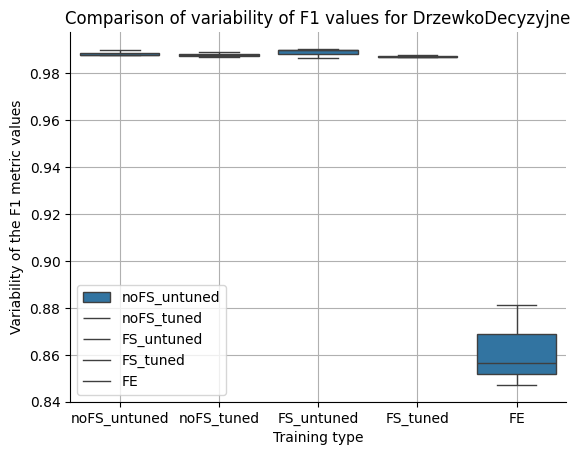

In [686]:
#The datatype of each feature of the dataframe.
dtypes = { "Make": "string", 
            "Model":"string",
            "Vehicle Class":"string",
            "Engine Size(L)":np.float64,
            "Cylinders":np.int16,
            "Transmission":"string",
            "Fuel Type":"string",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}


# Define the dictionary of  ML models we will be training.
Models = {
    "DrzewkoDecyzyjne": DecisionTreeClassifier(criterion="gini", splitter="best", min_samples_split=2), 
   # "LasLosowy": RandomForestClassifier(n_estimators=15, criterion='gini'), 
   # "KNN": KNeighborsClassifier(n_neighbors=5),
   # "RegresjaLogistyczna": LogisticRegression(multi_class = "ovr", max_iter = 250      )
 #  "RegresjaLiniowa":MultiOutputLinearRegression(LinearRegression())
}    

#For each ML model create it's corresponding parameter space.
Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini','entropy'],
                                       "splitter":['best','random'],
                                       "min_samples_split":[2,3],
                                        "min_samples_leaf":[2,3]},

                    "LasLosowy":{"n_estimators":list(range(5, 25, 5)),
                                        "min_samples_split":[2,3],
                                       "min_samples_leaf":[2,3]},
                                       
                  "KNN": {"n_neighbors":list(range(1, 10, 2)),
                            "p":[1,2]},
                            
                    #    "RegresjaLogistyczna": {
                      #  "max_iter":[250, 300]
                     #       "penalty":['l2'],
                      #        "solver":['liblinear','newton-cg',],
                              
                     #   },
                     "RegresjaLiniowa":{},
                             }




target_var: str = "CO2 Emissions(g/km)" #The target variable's name
file_name:str = "CO2Emission.csv" #The filename


n_splits:int = 3 # How many times we'll be learning each model.
train_size:float = 0.8 #The size of training set
test_size:float  = 1 - train_size #The size of testing set.


WielkiEstymator = ModelsComparisom(Filename = file_name, target_var = target_var, dtypes = dtypes, 
                                        Models = Models, Models_hipparams = Models_hipparams, 
                                        n_splits = n_splits, train_size  = train_size, test_size = test_size, 
                                        bins = [-float('inf'), 150, 250, float('inf')], show_plots = False
                                        )

WielkiEstymator.descriptive_statistics()
WielkiEstymator.train_models()
WielkiEstymator.compare_models()

In [687]:

# Pytania badawcze przykładowe:
# 1) Jak liczba klas docelowych wpływa na skuteczność metod? Czy skuteczność modelu domyślnie maleje, jeżeli liczba klas docelowych wzrośnie?
# 2) Jak skuteczne są metody proste w porównaniu z metodami bardziej zaawansowanymi.
# 3) Jak istotne jest strojenie parametrów? Czy statyczne strojenie parametrów ulega dynamicznego strojeniu parametrów.
# 4) Jak istotny jest wybór optymalnych cech? Czy należy uwzględnić wszystkie względne? A może wystarczy tylko kilka cech?
# 5) Jak prezentuje się dokładnośc predykcji w stosunku do poszczególnych klas? Czy klasy rzadsze są łatwiej przewidywalne?
        



#Typy wyboru cech.
#1) Filtry, czyli  kasujemy cechy, niezależnie od modelu, na podstawie statystyk.
#2) wrappers, czyli metody, które są "owinięte" wokół pewnego modelu.
#3) embedded methods.


#Jak sobie poradzić ze zmiennymi kategorycznymi wysoko-kardynalnymi 
#1)Weź to przeczytaj: https://github.com/rasbt/mlxtend/issues/502

# Najpierw ustal klasy, które są determinowane przez regulacje. Będzie ich trzy
# Potem ustaw własne progi dla klas emisyjności, aby liczba klas wzrosła do 5.
# Beamer w latexu do robienia prezentacji.


Co dalej do roboty?:
2) Zamknięćie wszystkich funkcji w jedną, potężna funkcję.
4) Liczenie wskaźników dokładności, jeżeli selekcja cech była wybierana automatycznie.